<a href="https://colab.research.google.com/github/confused-qy/Auto_mask_generator/blob/main/cholecseg8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the dataset

Downloaded the dataset.

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("newslab/cholecseg8k")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cholecseg8k' dataset.
Path to dataset files: /kaggle/input/cholecseg8k


Look at the data struct.

In [7]:
import os

print("Dataset directory structure: ")
for root, dirs, files in os.walk(path):
    print(root)
    break

Dataset directory structure: 
/kaggle/input/cholecseg8k


In [15]:
# def print_tree(startpath, depth=2):
#     for root, dirs, files in os.walk(startpath):
#         level = root.replace(startpath, "").count(os.sep)
#         if level > depth:
#             continue
#         indent = " " * 4 * level
#         print(f"{indent}{os.path.basename(root)}/")
#         subindent = " " * 4 * (level + 1)
#         for f in files[:5]:  # only print first 5 files in each directory
#             print(f"{subindent}{f}")

# print_tree(path, depth=2)
# print(path)

Example figures of the dataset.

/kaggle/input/cholecseg8k


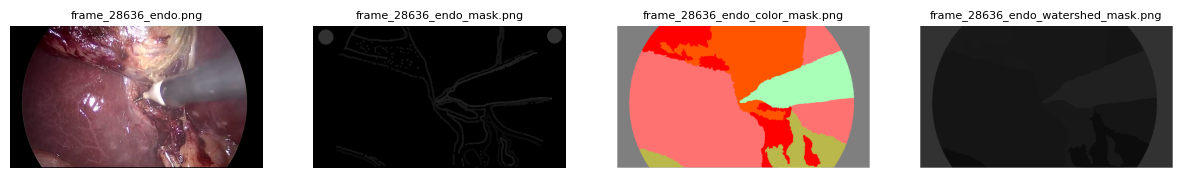

In [9]:
import cv2
import matplotlib.pyplot as plt

def show_multiple(base_path, filenames):
    plt.figure(figsize=(15, 5))
    for i, filename in enumerate(filenames, 1):
        target_path = None
        for root, dirs, files in os.walk(base_path):
            if filename in files:
                target_path = os.path.join(root, filename)
                break
        if target_path:
            img = cv2.imread(target_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, len(filenames), i)
            plt.imshow(img)
            plt.title(filename, fontsize=8)
            plt.axis("off")
        else:
            print(f"File {filename} not found in {base_path}")
    plt.show()

# Show the images
print(path)
show_multiple(path, [
    "frame_28636_endo.png",
    "frame_28636_endo_mask.png",
    "frame_28636_endo_color_mask.png",
    "frame_28636_endo_watershed_mask.png"
])

# Prepare for the Depth Figures

Download the model and setup the required packages

In [10]:
import os

print("Contents：", os.listdir())

if os.path.exists("Depth-Anything-V2"):
    print("Depth-Anything-V2 contents：", os.listdir("Depth-Anything-V2"))

Contents： ['.git', 'DA-2K.md', 'LICENSE', 'README.md', 'app.py', 'assets', 'depth_anything_v2', 'metric_depth', 'requirements.txt', 'run.py', 'run_video.py', 'checkpoints']


In [11]:
import sys
import numpy as np

print("Python path:", sys.executable)
print("Numpy version:", np.__version__)

if not hasattr(np, 'float32'):
    raise RuntimeError("Numpy is not available")

Python path: /usr/bin/python3
Numpy version: 1.26.4


In [12]:
%pip install numpy

import torch
import numpy as np

# Patch for torch numpy extension if needed
torch.utils._import_npy_extension = lambda: None

print(torch.__version__)
print(np.__version__)
print(torch.from_numpy(np.zeros((2,2))))

2.8.0+cu126
1.26.4
tensor([[0., 0.],
        [0., 0.]], dtype=torch.float64)


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Total 142 (delta 0), reused 0 (delta 0), pack-reused 142 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 43.27 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [13]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git /content/drive/MyDrive/Depth-Anything-V2

fatal: destination path '/content/drive/MyDrive/Depth-Anything-V2' already exists and is not an empty directory.


In [1]:
%cd /content/drive/MyDrive/Depth-Anything-V2
!pip install -r requirements.txt
!pip install opencv-python matplotlib huggingface_hub

/content/drive/MyDrive/Depth-Anything-V2


Evaluation of the model

In [4]:
import sys
sys.path.append("/content/drive/MyDrive/Depth-Anything-V2")

In [3]:
import torch
from depth_anything_v2.dpt import DepthAnythingV2

model = DepthAnythingV2(encoder='vitl', features=256, out_channels=[256, 512, 1024, 1024])
state_dict = torch.load('/content/drive/MyDrive/Depth-Anything-V2/checkpoints/depth_anything_v2_vitl.pth', map_location='cpu', weights_only=False)
model.load_state_dict(state_dict)
model.eval()

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=Fal

Example figure

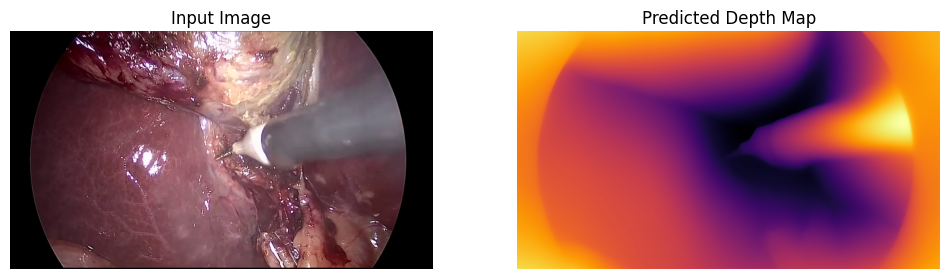

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# path of the figure
def find_image_path(base_path, filename):
    for root, dirs, files in os.walk(base_path):
        if filename in files:
            return os.path.join(root, filename)
    return None

base_path = path
filename = "frame_28636_endo.png"
image_path = find_image_path(base_path, filename)

# Read the image(BGR to RGB)
raw_img = cv2.imread(image_path)
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

depth_map = model.infer_image(raw_img)  # numpy array (H x W)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(raw_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Predicted Depth Map")
plt.imshow(depth_map, cmap='inferno')
plt.axis("off")

plt.show()